## Setup
Import required libraries.

In [ ]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import torch

from napari_dinosim.dinoSim_pipeline import *
from napari_dinosim.utils import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

import h5py
from torch.nn import functional as F

In [ ]:
#@title Data and Processing Parameters

#@markdown ### Data Settings
dataset_path = '/home/tomwelch/Cambridge/Datasets/neurotransmitter_data' #@param {type:"string"}
dates = os.listdir(dataset_path)#@param {type:"string"}
neurotransmitters = os.listdir(os.path.join(dataset_path, dates[0])) #@param {type:"string"} 

#@markdown ### Post-processing Settings
upsample = "bilinear" #@param {type:"string", options:["bilinear", "Nearest Neighbor", "None"], value-map:{bilinear:"bilinear", "Nearest Neighbor": "nearest", None:None}}
crop_shape = (512,512,1) #@param {type:"raw"}

#@markdown ### Model Input Settings
#@markdown Should be multiple of model patch_size
resize_size = 518 #@param {type:"integer"}

## Load Data


In [ ]:
def load_image(path):
    with h5py.File(path) as f:
        pre, post = f['annotations/locations'][:]/8
        x, y, z = pre[0].astype(int), pre[1].astype(int), pre[2].astype(int)
        slice_volume = f['volumes/raw'][:][:,:,z]
        return slice_volume, x, y

In [ ]:
train_x_fnames = glob(os.path.join(dataset_path, dates[0], neurotransmitters[0], '*.hdf*'))
train_x_fnames.sort()

train_dataset = np.stack([load_image(p)[0] for p in train_x_fnames]).astype(np.uint8)
train_dataset = train_dataset[...,np.newaxis] # add channel dim

coordinates = np.stack([load_image(p)[1:] for p in train_x_fnames])

print(f'N files:  {len(train_dataset)} \t Shape: {train_dataset.shape[1:]}')

# Load Model

In [ ]:
# select model size
model_size = 'small' #@param {type:"string", options:["small", "base", "large", "giant"]}

model_dims = {'small': 384, 'base': 768, 'large': 1024, 'giant': 1536}
assert model_size in model_dims, f'Invalid model size: ({model_size})'
model = torch.hub.load('facebookresearch/dinov2', f'dinov2_vit{model_size[0]}14_reg')
model.to(device)
model.eval()

feat_dim = model_dims[model_size]

few_shot = DinoSim_pipeline(model, model.patch_size, device, get_img_processing_f(resize_size),
                             feat_dim, dino_image_size=resize_size )
print("Model loaded")

# Prompting

In [ ]:
# select reference points
x, y = coordinates[0]+[-5,0]
points = [(0, x, y),]
z, x, y = zip(*points)

plt.imshow(train_dataset[z[0]], 'gray')
plt.scatter(x, y, c='r', marker='x')
plt.show()

# DinoSim

In [ ]:
def gaussian_kernel(size=3, sigma=1):

    upper = size - 1
    lower = -int(size / 2)

    y, x = np.mgrid[lower:upper, lower:upper]

    kernel = (1 / (2 * np.pi * sigma**2)) * np.exp(
        -(x**2 + y**2) / (2 * sigma**2)
    )
    kernel = kernel / kernel.sum()

    return kernel

In [ ]:
def torch_convolve(input, weights, mode="reflect", cval=0.0, origin=0):
    """
    Multidimensional convolution using PyTorch.

    Parameters
    ----------
    input : torch.Tensor
        The input tensor to be convolved.
    weights : torch.Tensor
        Convolution kernel, with the same number of dimensions as the input.
    mode : str, optional
        Padding mode. Options are 'reflect', 'constant', 'replicate', or 'circular'.
        Default is 'reflect'.
    cval : float, optional
        Value to fill past edges of input if `mode` is 'constant'. Default is 0.0.
    origin : int, optional
        Controls the origin of the input signal. Positive values shift the filter
        to the right, and negative values shift the filter to the left. Default is 0.

    Returns
    -------
    result : torch.Tensor
        The result of convolution of `input` with `weights`.
    """
    # Ensure input is 4D (batch, channels, height, width)
    if input.dim() == 2:  # Single channel 2D image
        input = input.unsqueeze(0).unsqueeze(0)
    elif input.dim() == 3:  # Add batch dimension if missing
        input = input.unsqueeze(0)

    # Add channel dimension for weights if necessary
    if weights.dim() == 2:
        weights = weights.unsqueeze(0).unsqueeze(0)

    # Apply padding based on mode
    padding = (
        weights.shape[-1] // 2 - origin
    )  # Adjust padding for origin shift
    input_padded = F.pad(
        input, (padding, padding, padding, padding), mode=mode, value=cval
    )

    # Perform convolution
    result = F.conv2d(input_padded, weights)

    return result.squeeze()  # Remove extra dimensions for output

In [ ]:
#Post-processing
kernel = gaussian_kernel(size=3, sigma=1)
kernel = torch.tensor(kernel, dtype=torch.float32, device=device)
filter_f = lambda x: torch_convolve(x, kernel)

#few_shot.delete_precomputed_embeddings()
# few_shot.delete_references()
if not few_shot.emb_precomputed:
    few_shot.pre_compute_embeddings(train_dataset, overlap = (0,0), padding=(0,0), crop_shape=crop_shape, verbose=True, batch_size=5)
few_shot.set_reference_vector(list_coords=points)
distances = few_shot.get_ds_distances_sameRef(verbose=False)
predictions = few_shot.distance_post_processing(distances, filter_f, upsampling_mode=upsample)
print("Finished")

In [ ]:
predictions[6].shape

# Plot results

In [ ]:
# select threshold
threshold = 0.5

for i in range(1):
    input_img = train_dataset[i]
    plt.figure(figsize=(12,7))
    plt.subplot(131)
    if input_img.shape[-1] == 1:
        plt.imshow(input_img[...,0], 'gray')
    else:
        plt.imshow(input_img)
    plt.subplot(132)
    plt.imshow(1-predictions[i], 'magma')
    plt.subplot(133)
    plt.imshow(predictions[i] < threshold, 'gray')
    plt.show()

In [ ]:
def get_bbox(predictions, threshold):
    bbox_list = []
    failed = []
    try:
        for i in range(predictions.shape[0]):
            GT = (predictions[i] < threshold).astype(np.uint8)
            if np.sum(GT) == 0:
                failed.append(i)
                continue
            bbox_1x, bbox_1y = min(np.where(GT == 1)[1])-5, min(np.where(GT == 1)[0])-5
            bbox_2x, bbox_2y = max(np.where(GT == 1)[1])+5, max(np.where(GT == 1)[0])+5
            bbox_list.append(((bbox_1x, bbox_2x), (bbox_1y, bbox_2y)))
    except Exception as e:
        print(f"Error in bbox nb.{i}: {e}")
    
    print(f"{len(failed)/predictions.shape[0]*100}% of images did not pass the threshold")
    return bbox_list, len(failed)/predictions.shape[0]*100

In [ ]:
bboxes, _ = get_bbox(predictions, 0.35)

In [ ]:
def f(threshold):
    return get_bbox(predictions, threshold)[1]

plt.figure(figsize=(12,7), dpi=300)
thresholds = np.arange(0, 1.05, 0.05)
plt.plot(thresholds, [f(threshold)for threshold in thresholds])

___
# Implementation 

# Setup

In [57]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import torch

from napari_dinosim.dinoSim_pipeline import *
from napari_dinosim.utils import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

import h5py
from torch.nn import functional as F
import torchvision.transforms.v2.functional as T
from torchvision import transforms
from tqdm import tqdm
import matplotlib.patches as patches

Device: cpu


In [58]:
def load_image(path):
    with h5py.File(path) as f:
        pre, post = f['annotations/locations'][:]/8
        x, y, z = pre[0].astype(int), pre[1].astype(int), pre[2].astype(int)
        slice_volume = f['volumes/raw'][:][np.newaxis,:,:,z]
        return slice_volume, x, y

In [84]:
def get_bbox(predictions, threshold):
    GT = (predictions[0,...] < threshold).astype(np.float32)
    bbox_1x, bbox_1y = min(np.where(GT == 1)[1])-5, min(np.where(GT == 1)[0])-5
    bbox_2x, bbox_2y = max(np.where(GT == 1)[1])+5, max(np.where(GT == 1)[0])+5
    return bbox_1x, bbox_2x, bbox_1y, bbox_2y
    #print(f"{len(failed)/predictions.shape[0]*100}% of images did not pass the threshold")

In [60]:
def f(predictions, threshold):
    return get_bbox(predictions, threshold)[1]

In [61]:
#@title Data and Processing Parameters

#@markdown ### Data Settings
#dataset_path = '/home/tomwelch/Cambridge/Datasets/neurotransmitter_data' #@param {type:"string"}
dataset_path = '/Users/tomw/Documents/MVA/Internship/Cambridge/Datasets/neurotransmitter_data'
dates = glob(os.path.join(dataset_path, '*')) #@param {type:"string"}
neurotransmitters = list(map(lambda x: os.path.basename(os.path.normpath(x)), glob(os.path.join(dates[0], '*')))) #@param {type:"string"} 

#@markdown ### Post-processing Settings
upsample = "bilinear" #@param {type:"string", options:["bilinear", "Nearest Neighbor", "None"], value-map:{bilinear:"bilinear", "Nearest Neighbor": "nearest", None:None}}
crop_shape = (512,512,1) #@param {type:"raw"}

#@markdown ### Model Input Settings
#@markdown Should be multiple of model patch_size
resize_size = 518 #@param {type:"integer"}

In [62]:
# select model size
model_size = 'small' #@param {type:"string", options:["small", "base", "large", "giant"]}

model_dims = {'small': 384, 'base': 768, 'large': 1024, 'giant': 1536}
assert model_size in model_dims, f'Invalid model size: ({model_size})'
model = torch.hub.load('facebookresearch/dinov2', f'dinov2_vit{model_size[0]}14_reg')
model.to(device)
model.eval()

feat_dim = model_dims[model_size]

few_shot = DinoSim_pipeline(model, model.patch_size, device, get_img_processing_f(resize_size),
                             feat_dim, dino_image_size=resize_size )
print("Model loaded")

Using cache found in /Users/tomw/.cache/torch/hub/facebookresearch_dinov2_main


Model loaded


In [63]:
def DINOSim():
    '''
    Runs few-shot DINO-based detection over all dates and 6 neurotransmitters,
    and plots success rate over thresholds in a 2x3 subplot grid.
    '''
    thresholds = np.arange(0, 1.05, 0.05)

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()

    for i, neuro in enumerate(neurotransmitters):
        all_success_rates = []

        for date in dates:
            # Load files
            train_x_fnames = glob(os.path.join(dataset_path, date, neuro, '*.hdf*'))
            train_x_fnames.sort()

            # Skip if no data
            if len(train_x_fnames) == 0:
                print(f"Skipping {neuro} on {dates[date]} (no data)")
                continue

            train_dataset = np.stack([load_image(p)[0] for p in train_x_fnames])
            train_dataset = train_dataset[..., np.newaxis]
            coordinates = np.stack([load_image(p)[1:] for p in train_x_fnames])
            points = [(0, coord[0], coord[1]) for coord in coordinates]

            # Convolution kernel
            kernel = gaussian_kernel(size=3, sigma=1)
            kernel = torch.tensor(kernel, dtype=torch.float32, device=device)
            filter_f = lambda x: torch_convolve(x, kernel)

            # Few-shot setup
            few_shot.delete_precomputed_embeddings()
            few_shot.delete_references()
            if not few_shot.emb_precomputed:
                few_shot.pre_compute_embeddings(train_dataset[:50], 
                                                overlap=(0, 0),
                                                padding=(0, 0),
                                                crop_shape=crop_shape, 
                                                verbose=False,
                                                batch_size=5)
            print('Done')
            predictions = []

            for point in tqdm(points, desc=f'{neuro} on {date}'):
                few_shot.set_reference_vector(list_coords=[(0, point[0], point[1])])
                distances = few_shot.get_ds_distances_sameRef(verbose=False)
                pred = few_shot.distance_post_processing(distances, filter_f, upsampling_mode=upsample)
                predictions.append(pred)

            predictions = np.array(predictions)
            failure_rate = [f(predictions, t) for t in thresholds]
            all_failure_rates.append(failure_rate)

        # Average across dates
        if all_success_rates:
            mean_rates = np.mean(all_success_rates, axis=0)
            axs[i].plot(thresholds, mean_rates, label=neuro)
            axs[i].set_title(f'{neuro}')
            axs[i].set_xlabel('Threshold')
            axs[i].set_ylabel('Success Rate')
            axs[i].grid(True)
            axs[i].legend()

    plt.suptitle('Success Rate vs Threshold for Neurotransmitters', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [64]:
#DINOSim()

In [81]:
def Images_DINOSim(threshold):
    '''
    Runs few-shot DINO-based detection over all dates and 6 neurotransmitters,
    and plots first 5 samples.
    '''
    
    # Convolution kernel
    kernel = gaussian_kernel(size=3, sigma=1)
    kernel = torch.tensor(kernel, dtype=torch.float32, device=device)
    filter_f = lambda x: torch_convolve(x, kernel)
    
    for date in dates:
        date_name = os.path.basename(os.path.normpath(date))
        
        for neuro in neurotransmitters:
            print('Loading data')
            # Load files
            train_x_fnames = glob(os.path.join(date, neuro, '*.hdf*'))
            train_x_fnames.sort()

            # Skip if no data
            if len(train_x_fnames) == 0:
                print(f"Skipping {neuro} in {date_name} (no data)")
                continue

            dataset = np.stack([load_image(p)[0] for p in train_x_fnames])
            dataset = dataset[..., np.newaxis]
            coordinates = np.stack([load_image(p)[1:] for p in train_x_fnames])

            predictions = []
            bboxes_list = []
            print('Done loading data')
            for k in tqdm(range(len(dataset[:10])), desc=f'Processing {neuro} from {date_name}', leave=True):
                few_shot.delete_precomputed_embeddings()
                few_shot.delete_references()
                if not few_shot.emb_precomputed:
                    few_shot.pre_compute_embeddings(dataset[k], 
                                                    overlap=(0, 0),
                                                    padding=(0, 0),
                                                    crop_shape=crop_shape, 
                                                    verbose=False,
                                                    batch_size=1)

                few_shot.set_reference_vector(list_coords=[(0, coordinates[k][0], coordinates[k][1])])
                distances = few_shot.get_ds_distances_sameRef(verbose=False)
                pred = few_shot.distance_post_processing(distances, filter_f, upsampling_mode=upsample)
                bboxes_list.append(get_bbox(pred, threshold))
                predictions.append(pred)

            for i in range(5):
                input_img = dataset[i]
                plt.figure(figsize=(12,7))
                plt.subplot(131)
                if input_img.shape[-1] == 1:
                    plt.imshow(input_img[0,...,0], 'gray')
                else:
                    plt.imshow(input_img)
                plt.scatter(coordinates[i][0], coordinates[i][1], color='red', marker='x')
                w = bboxes_list[i][1] - bboxes_list[i][0]
                h = bboxes_list[i][3] - bboxes_list[i][2]
                x, y = bboxes_list[i][0], bboxes_list[i][2]
                patches.Rectangle((x,y), w, h)
                plt.scatter(bboxes_list[i][0], bboxes_list[i][1], color='blue', marker='o')
                plt.subplot(132)
                plt.imshow(1-predictions[i][0,...], 'magma')
                plt.subplot(133)
                plt.imshow(predictions[i][0,...] < threshold, 'gray')
                plt.tight_layout()
                plt.show()        

Loading data
Done loading data


Processing dopamine from sylee_neurotrans_cubes_24Mar2025:   0%|          | 0/10 [00:00<?, ?it/s]

Precomputing embeddings


Processing dopamine from sylee_neurotrans_cubes_24Mar2025:  10%|█         | 1/10 [00:00<00:05,  1.64it/s]

Precomputing embeddings


Processing dopamine from sylee_neurotrans_cubes_24Mar2025:  20%|██        | 2/10 [00:01<00:04,  1.70it/s]

Precomputing embeddings


Processing dopamine from sylee_neurotrans_cubes_24Mar2025:  30%|███       | 3/10 [00:01<00:04,  1.67it/s]

Precomputing embeddings


Processing dopamine from sylee_neurotrans_cubes_24Mar2025:  40%|████      | 4/10 [00:02<00:03,  1.67it/s]

Precomputing embeddings


Processing dopamine from sylee_neurotrans_cubes_24Mar2025:  50%|█████     | 5/10 [00:03<00:03,  1.62it/s]

Precomputing embeddings


Processing dopamine from sylee_neurotrans_cubes_24Mar2025:  60%|██████    | 6/10 [00:03<00:02,  1.61it/s]

Precomputing embeddings


Processing dopamine from sylee_neurotrans_cubes_24Mar2025:  70%|███████   | 7/10 [00:04<00:02,  1.49it/s]

Precomputing embeddings


Processing dopamine from sylee_neurotrans_cubes_24Mar2025:  80%|████████  | 8/10 [00:05<00:01,  1.56it/s]

Precomputing embeddings


Processing dopamine from sylee_neurotrans_cubes_24Mar2025:  90%|█████████ | 9/10 [00:05<00:00,  1.59it/s]

Precomputing embeddings


Processing dopamine from sylee_neurotrans_cubes_24Mar2025: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


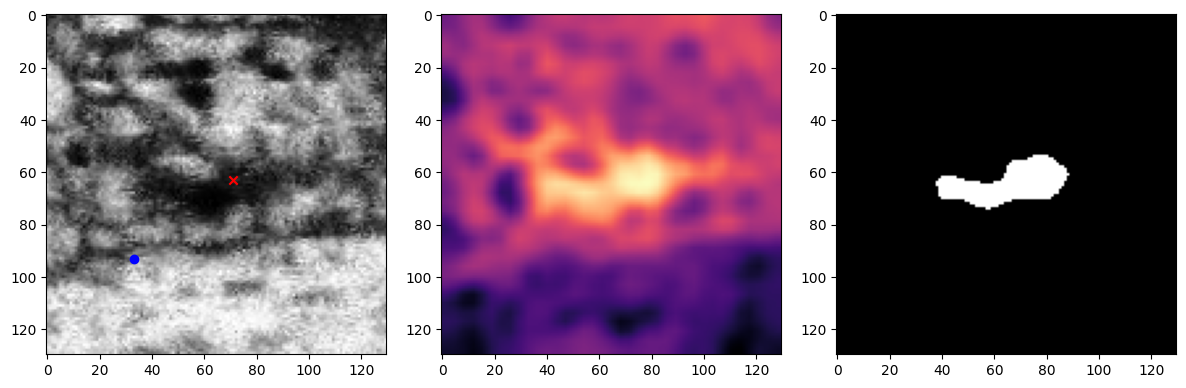

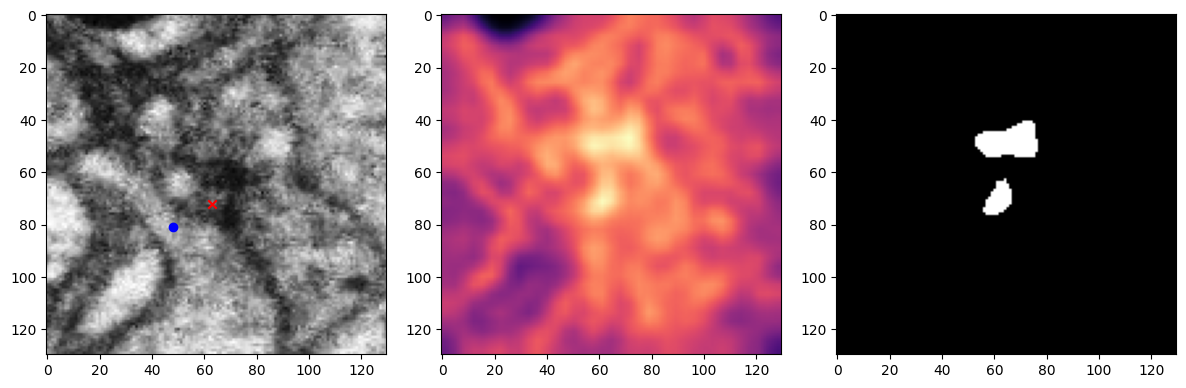

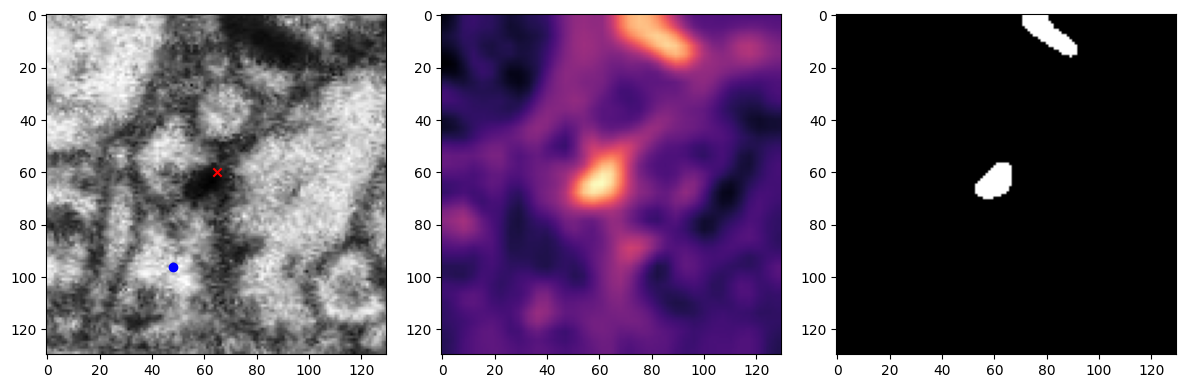

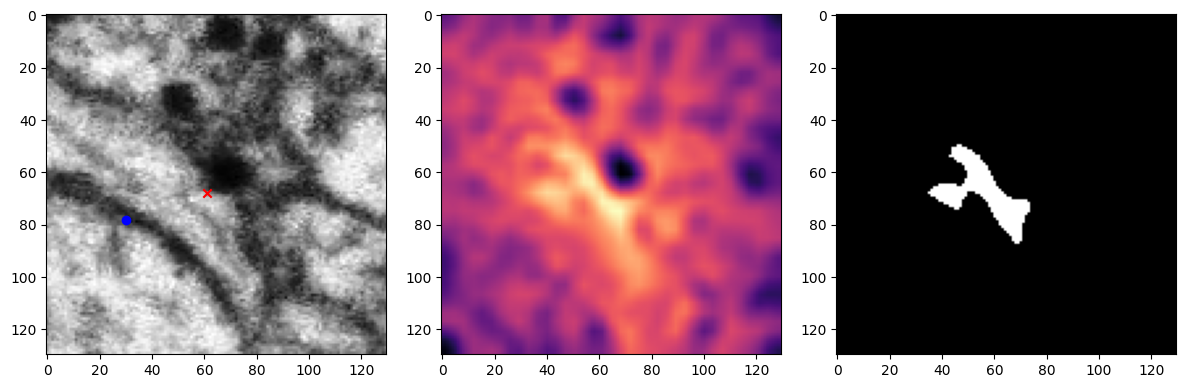

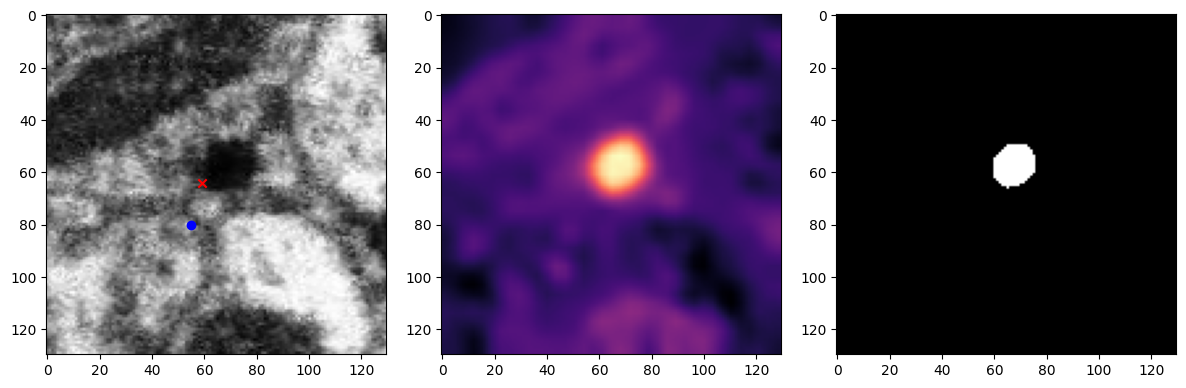

Loading data
Done loading data


Processing gaba from sylee_neurotrans_cubes_24Mar2025:   0%|          | 0/10 [00:00<?, ?it/s]

Precomputing embeddings


Processing gaba from sylee_neurotrans_cubes_24Mar2025:  10%|█         | 1/10 [00:00<00:04,  1.82it/s]

Precomputing embeddings


Processing gaba from sylee_neurotrans_cubes_24Mar2025:  20%|██        | 2/10 [00:01<00:04,  1.78it/s]

Precomputing embeddings


Processing gaba from sylee_neurotrans_cubes_24Mar2025:  30%|███       | 3/10 [00:01<00:03,  1.80it/s]

Precomputing embeddings


Processing gaba from sylee_neurotrans_cubes_24Mar2025:  40%|████      | 4/10 [00:02<00:03,  1.76it/s]

Precomputing embeddings


Processing gaba from sylee_neurotrans_cubes_24Mar2025:  50%|█████     | 5/10 [00:02<00:02,  1.80it/s]

Precomputing embeddings


Processing gaba from sylee_neurotrans_cubes_24Mar2025:  60%|██████    | 6/10 [00:03<00:02,  1.82it/s]

Precomputing embeddings


Processing gaba from sylee_neurotrans_cubes_24Mar2025:  70%|███████   | 7/10 [00:03<00:01,  1.81it/s]

Precomputing embeddings


Processing gaba from sylee_neurotrans_cubes_24Mar2025:  80%|████████  | 8/10 [00:04<00:01,  1.84it/s]

Precomputing embeddings


Processing gaba from sylee_neurotrans_cubes_24Mar2025:  90%|█████████ | 9/10 [00:04<00:00,  1.83it/s]

Precomputing embeddings


Processing gaba from sylee_neurotrans_cubes_24Mar2025: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


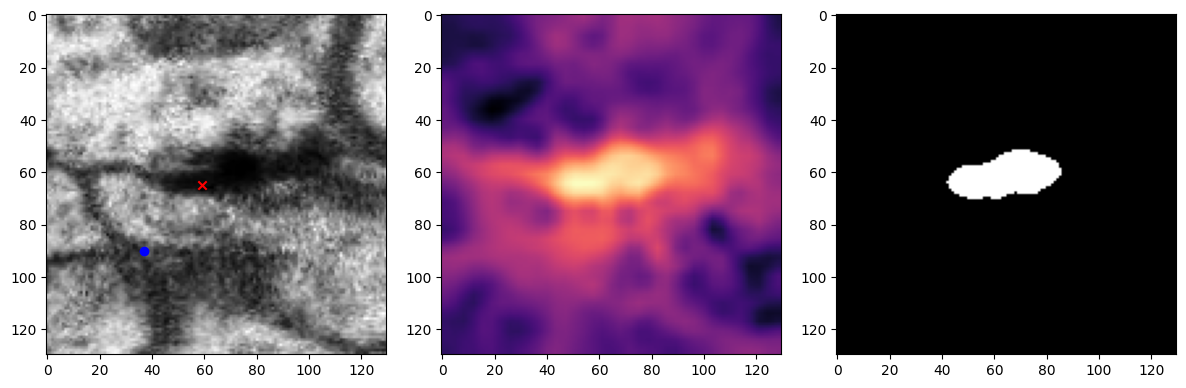

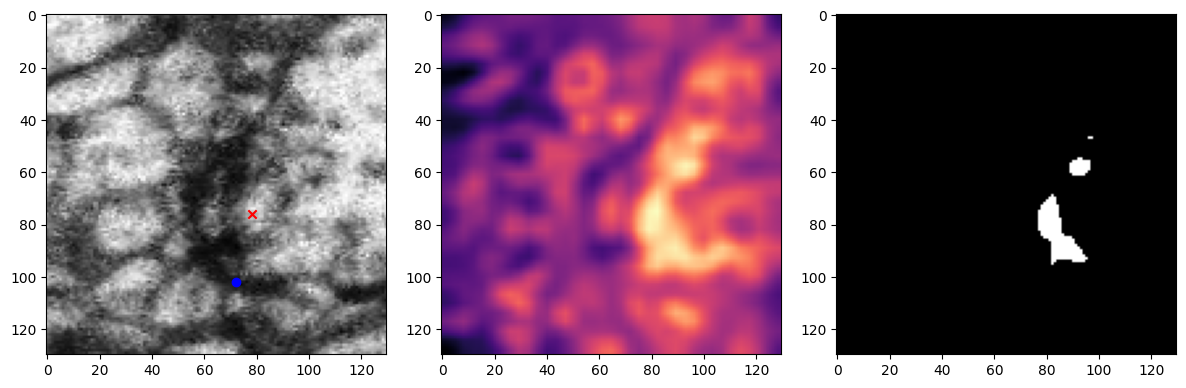

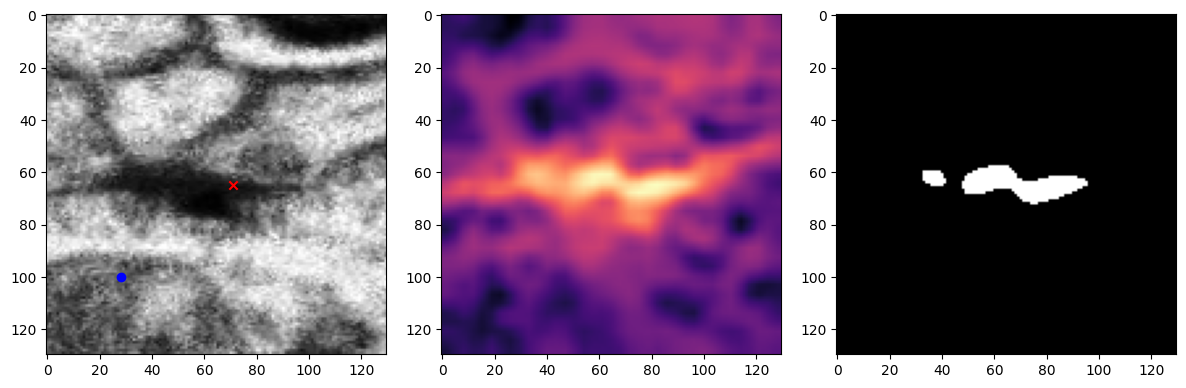

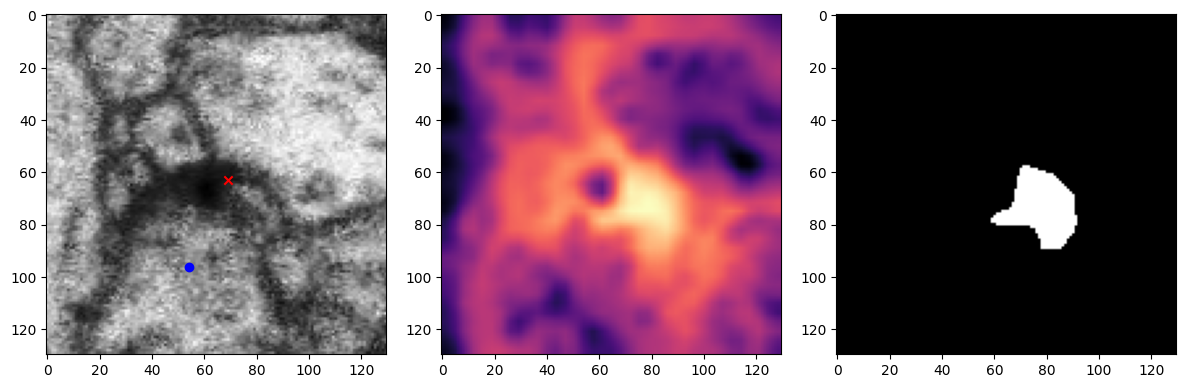

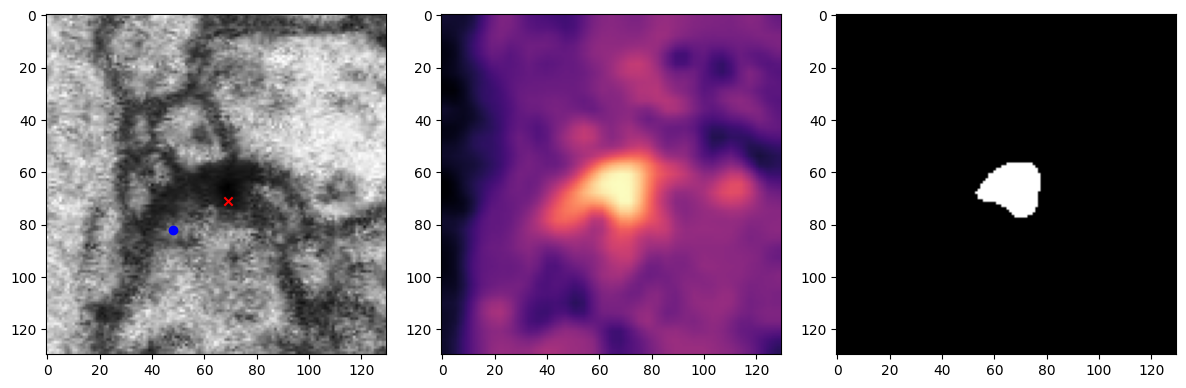

Loading data
Done loading data


Processing octopamine from sylee_neurotrans_cubes_24Mar2025:   0%|          | 0/10 [00:00<?, ?it/s]

Precomputing embeddings


Processing octopamine from sylee_neurotrans_cubes_24Mar2025:  10%|█         | 1/10 [00:00<00:04,  1.99it/s]

Precomputing embeddings


Processing octopamine from sylee_neurotrans_cubes_24Mar2025:  20%|██        | 2/10 [00:01<00:04,  1.83it/s]

Precomputing embeddings


Processing octopamine from sylee_neurotrans_cubes_24Mar2025:  30%|███       | 3/10 [00:01<00:03,  1.85it/s]

Precomputing embeddings


Processing octopamine from sylee_neurotrans_cubes_24Mar2025:  40%|████      | 4/10 [00:02<00:03,  1.81it/s]

Precomputing embeddings


Processing octopamine from sylee_neurotrans_cubes_24Mar2025:  50%|█████     | 5/10 [00:02<00:02,  1.78it/s]

Precomputing embeddings


Processing octopamine from sylee_neurotrans_cubes_24Mar2025:  60%|██████    | 6/10 [00:03<00:02,  1.83it/s]

Precomputing embeddings


Processing octopamine from sylee_neurotrans_cubes_24Mar2025:  70%|███████   | 7/10 [00:03<00:01,  1.85it/s]

Precomputing embeddings


Processing octopamine from sylee_neurotrans_cubes_24Mar2025:  80%|████████  | 8/10 [00:04<00:01,  1.81it/s]

Precomputing embeddings


Processing octopamine from sylee_neurotrans_cubes_24Mar2025:  90%|█████████ | 9/10 [00:04<00:00,  1.84it/s]

Precomputing embeddings


Processing octopamine from sylee_neurotrans_cubes_24Mar2025: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


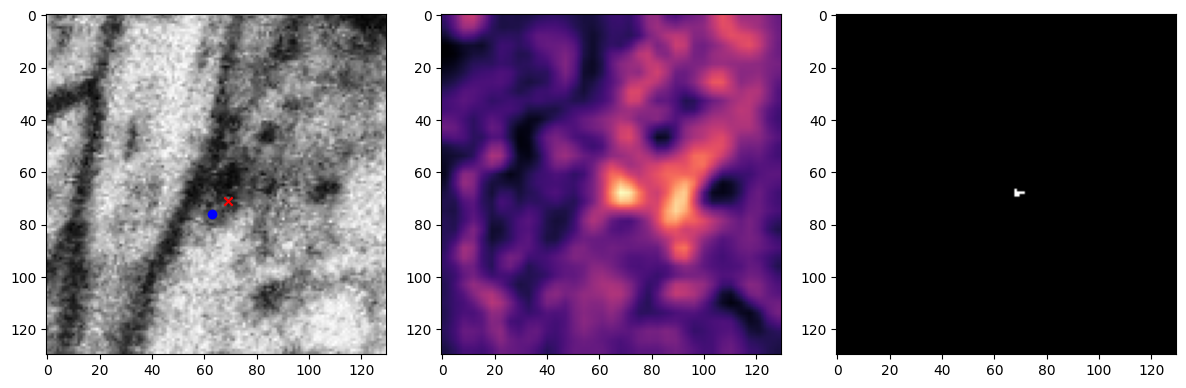

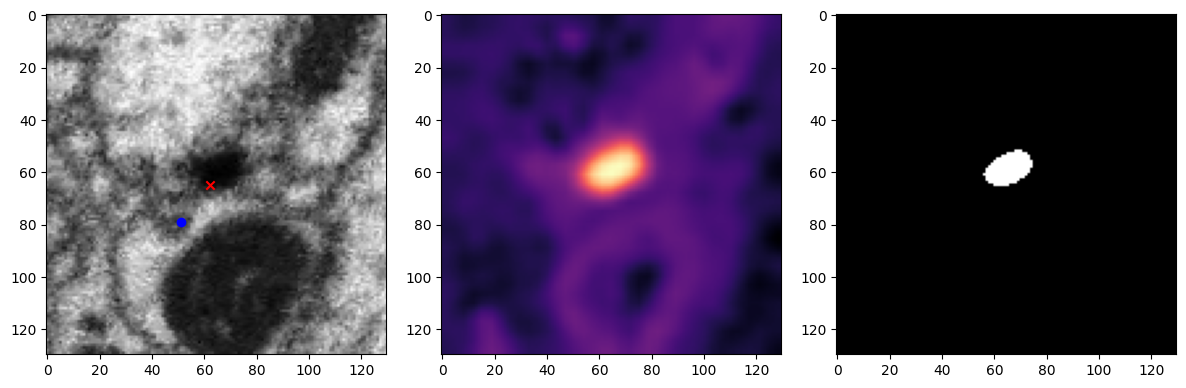

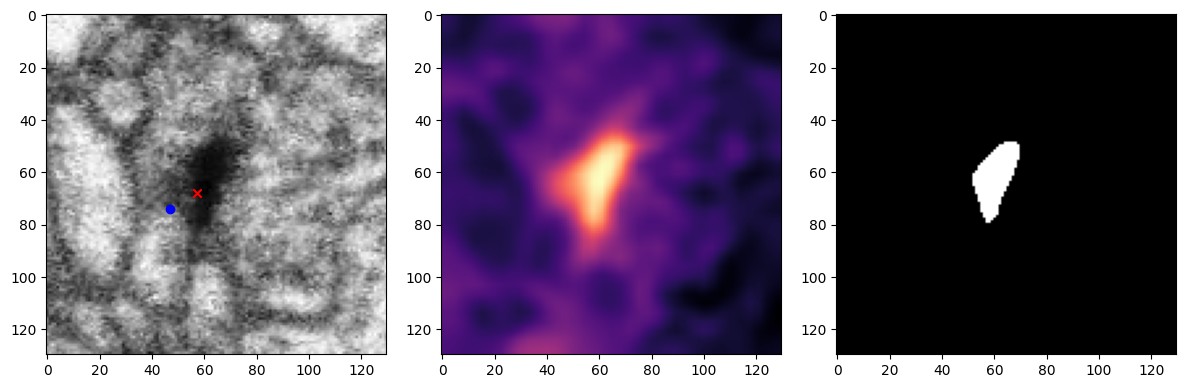

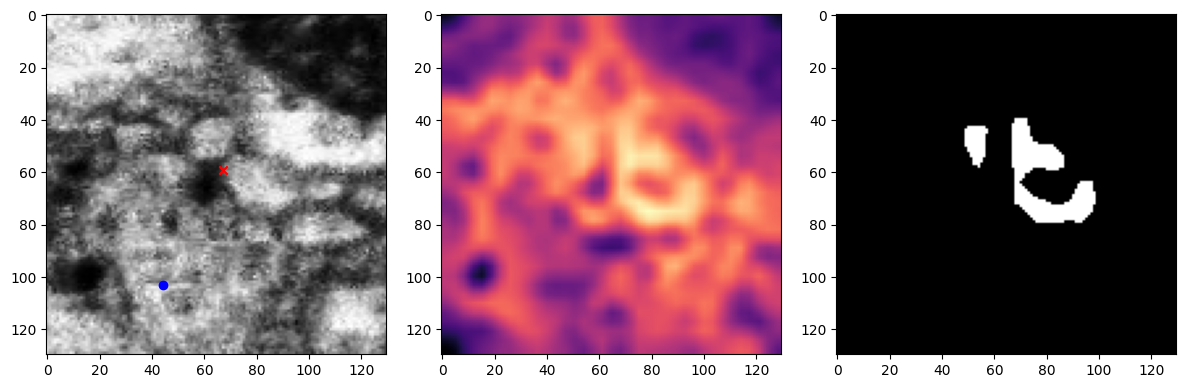

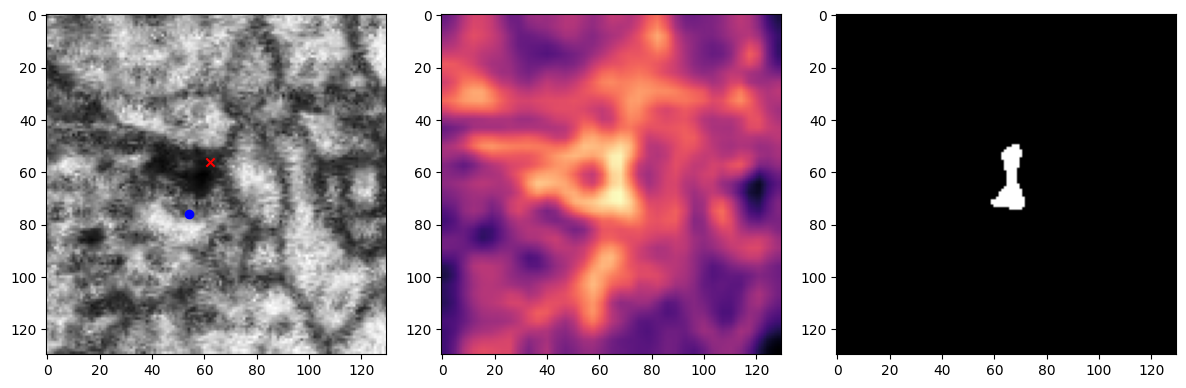

Loading data


KeyboardInterrupt: 

In [83]:
Images_DINOSim(0.2)